# COE 476 - Neural Networks Final Project

**by Sara Raya, Mahira Pathan, and Eyad Mohamed Ali**

## Importing all necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import gdown
import matplotlib
matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt

## Getting directories ready for models

In [ ]:
# working directory could be changed with the following block of code
# os.chdir("NEW_PATH")

# Change any of these to a location in your mounted drive if you want to keep
# the data safe from colab crashing
gen_img_dir = "gen_img"
metrics_dir = "/content/drive/MyDrive/metricsGAN" #"metrics" change back to this if you want local storage
models_dir = "models"
path_to_data = "Dataset"

try:
  os.mkdir(gen_img_dir)
except FileExistsError:
  print(gen_img_dir + " already exists")
try:
  os.mkdir(metrics_dir)
except FileExistsError:
  print(metrics_dir + " already exists")
  pass
try:
  os.mkdir(models_dir)
except FileExistsError:
  print(models_dir + " already exists")
  pass
try:
  os.mkdir(models_dir+"/discriminator")
except FileExistsError:
  print(models_dir + "/discriminator already exists")
  pass
try:
  os.mkdir(models_dir+"/generator")
except FileExistsError:
  print(models_dir + "/generator already exists")
  pass
try:
  os.mkdir(path_to_data)
except FileExistsError:
  print(path_to_data + " already exists")
  pass

print(f"Current working directory: {os.getcwd()}")
print(f"Generated images will be saved in: {os.getcwd()}/{gen_img_dir}")
print(f"Model information will be saved in: {os.getcwd()}/{models_dir}")
print(f"Metrics (loss graphs and more) will be saved in: {os.getcwd()}/{metrics_dir}")
print(f"Data will be accessed from: {os.getcwd()}/{path_to_data}")

gen_img already exists
/content/drive/MyDrive/metricsGAN already exists
models already exists
models/discriminator already exists
models/generator already exists
Dataset already exists
Current working directory: /content
Generated images will be saved in: /content/gen_img
Model information will be saved in: /content/models
Metrics (loss graphs and more) will be saved in: /content//content/drive/MyDrive/metricsGAN
Data will be accessed from: /content/Dataset


## Downloading the dataset

In [ ]:
id = "1LOYohtmrumYRh5i3b0zOcxXWzrEf4Jdj"
output = "dataset.rar"
gdown.download(id=id,output= output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1LOYohtmrumYRh5i3b0zOcxXWzrEf4Jdj
To: /content/dataset.rar
100%|██████████| 623M/623M [00:03<00:00, 173MB/s]


'dataset.rar'

In [ ]:
# https://www.tecmint.com/how-to-open-extract-and-create-rar-files-in-linux/
!unrar x dataset.rar /content/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from dataset.rar


Would you like to replace the existing file /content/Dataset/Monet/00001.jpg
 86678 bytes, modified on 2020-09-01 19:31
with a new one
 86678 bytes, modified on 2020-09-01 19:31

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  /content/Dataset/Monet/00001.jpg                               0%  OK 

Would you like to replace the existing file /content/Dataset/Monet/00003.jpg
 17184 bytes, modified on 2020-09-01 19:31
with a new one
 17184 bytes, modified on 2020-09-01 19:31

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/Dataset/Monet/00003.jpg                               0%  OK 
Extracting  /content/Dataset/Monet/00004.jpg                               0%  OK 
Extracting  /content/Dataset/Monet/00006.jpg                               0%  OK 
Extracting  /content/Dataset/Monet/00007.jpg                             

## Parameters

In [ ]:
# Batch size
batch_size = 64
# Number of channels (RGB so 3)
num_channels = 3
# Number of classes for cGAN (here classes are number of artists)
num_classes = 3
# The size of the images we choose to use
image_size = 128
# The size of the input, z, we will input into the generator
latent_dim = 150

## Building dataset

In [ ]:
dataGen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3, 
    height_shift_range=0.3,
    validation_split=0.02,
    )

In [ ]:
train_ds = dataGen.flow_from_directory(
        path_to_data,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to image_sizeximage_size
        color_mode='rgb',
        batch_size=batch_size,
        subset='training')

valid_ds = dataGen.flow_from_directory(
        path_to_data,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to image_sizeximage_size
        color_mode='rgb',
        batch_size=86, #gonna basically be a testing dataset
        subset='validation')

print(f"Classes: {train_ds.class_indices}")
print(f"Number of classes from generator: {len(train_ds.class_indices)}")
print(f"Number of classes from parameters: {num_classes}")

Found 4293 images belonging to 3 classes.
Found 86 images belonging to 3 classes.
Classes: {'Monet': 0, 'Picasso': 1, 'Van Gogh': 2}
Number of classes from generator: 3
Number of classes from parameters: 3


## Building Generator and Discriminator

In [ ]:
# input channels for the upcoming cGANs, as inspired by https://keras.io/examples/generative/conditional_gan/
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(f"Generator input channels: {generator_in_channels}")
print(f"Discriminator input channels: {discriminator_in_channels}")

Generator input channels: 153
Discriminator input channels: 6


### Discriminator

In [ ]:
def get_discriminator():
    # Create the discriminator. Inspired by http://cs-chan.com/doc/ArtGAN_supp.pdf
    discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.2),
            layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.2),
            layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.2),
            layers.Conv2D(1024, (3, 3), strides=(2, 2), padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Flatten(),
            layers.Dense(1, activation=tf.keras.activations.sigmoid),

        ],
        name="discriminator",
    )

    # Save and display the image of the Discriminator model
    tf.keras.utils.plot_model(
        discriminator,
        to_file=models_dir+"/discriminator/discriminator.png",
        show_shapes=True,
    )

    return discriminator

### Generator

In [ ]:
# Create the generator.
def get_generator():
    generator = keras.Sequential(
        [
            keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 8x8x(128 + num_classes) map.
            layers.Dense(8 * 8 * 512),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.Reshape((8, 8, 512)),
            layers.UpSampling2D(2),
            layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.UpSampling2D(2),
            layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.UpSampling2D(2),
            layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.UpSampling2D(2),
            layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            layers.Conv2D(3, (3, 3), strides=(1, 1), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
        ],
        name="generator",
    )

    # Save and display the image of the Generator model
    tf.keras.utils.plot_model(
        generator,
        to_file=models_dir+"/generator/generator.png",
        show_shapes=True,
    )

    return generator

## cGAN class

In [ ]:
####################ORIGINAL CONDITIONAL GAN CLASS########################
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.disc_acc_tracker = keras.metrics.Mean(name="discriminator_acc")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.disc_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.acc_fn = tf.keras.metrics.BinaryAccuracy(name="disc_binary_accuracy", dtype=None, threshold=0.5)

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            d_acc = self.acc_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.disc_acc_tracker.update_state(d_acc)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_acc": self.disc_acc_tracker.result(),
        }

## Custom callback: GANMonitor

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=150, b = 0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.batch = b
        self.classData = tf.cast(tf.concat([np.eye(num_classes) for _ in range(self.num_img)], axis=0), tf.float32)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img*num_classes, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, self.classData], axis=1
        )
        generated_images = self.model.generator(random_vector_labels)
        generated_images *= 255
        generated_images.numpy()
        j = 0
        for i in range(self.num_img * num_classes):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(gen_img_dir+"/generated_img_%d_%d_%d.png" % (epoch, j, i%3)) # changed this line to save in a nested directory EPOHC, ARTIST, PAINTING
            if i % self.num_img == self.num_img-1:
              j+=1

## Training

### Compile

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=get_discriminator(), generator=get_generator(), latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

### Fit

In [ ]:
dloss=[]
gloss=[]
dacc=[]
# Update the loss graph after every 25 epochs to make sure we continue to have an updated graph even if training halts

history = cond_gan.fit(train_ds, epochs=5, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)])
dloss = tf.concat([dloss,history.history['d_loss']], axis=0)
gloss = tf.concat([gloss,history.history['g_loss']], axis=0)
dacc = tf.concat([dacc,history.history['d_acc']], axis=0)
# let us plot the metrics
epoch = np.arange(0,len(dloss))
plt.plot(epoch, dloss, 'm-')
plt.title("discriminator loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.savefig(metrics_dir+"/dloss.png", bbox_inches='tight', pad_inches=0.2)
plt.close('all')
plt.plot(epoch, gloss, 'c-')
plt.title("generator loss") 
plt.ylabel("loss") 
plt.xlabel('epoch')
plt.savefig(metrics_dir+"/gloss.png", bbox_inches='tight', pad_inches=0.2)
plt.close('all')
plt.plot(epoch, dacc, 'r-')
plt.title("discriminator accuracy")
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.savefig(metrics_dir+"/dacc.png", bbox_inches='tight', pad_inches=0.2)
plt.close('all')

Epoch 1/5
68/68 [==============================] - 84s 1s/step - g_loss: 1.7502 - d_loss: 0.7905 - d_acc: 0.5648
Epoch 2/5
68/68 [==============================] - 79s 1s/step - g_loss: 3.2324 - d_loss: 1.2038 - d_acc: 0.6199
Epoch 3/5
68/68 [==============================] - 77s 1s/step - g_loss: 1.4757 - d_loss: 0.7254 - d_acc: 0.5873
Epoch 4/5
68/68 [==============================] - 96s 1s/step - g_loss: 2.5007 - d_loss: 0.7444 - d_acc: 0.5752
Epoch 5/5
68/68 [==============================] - 127s 2s/step - g_loss: 2.7541 - d_loss: 0.9485 - d_acc: 0.5763


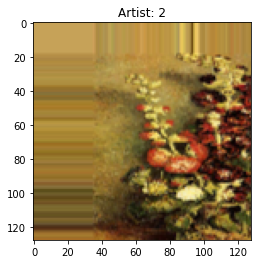

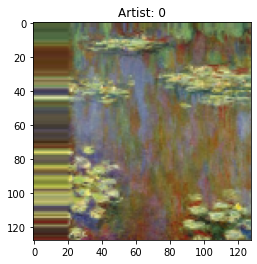

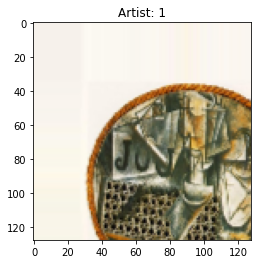

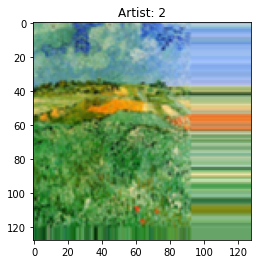

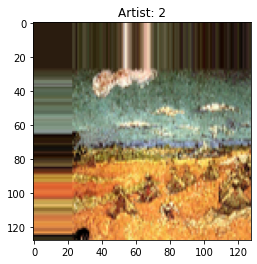

In [ ]:
img, lbl = next(iter(train_ds))
for i in range(5):
  plt.imshow(img[i])
  plt.title(f"Artist: {np.argmax(lbl[i])}")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


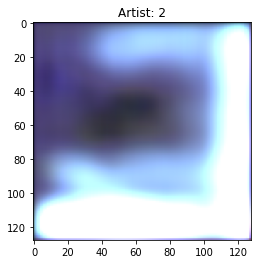

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


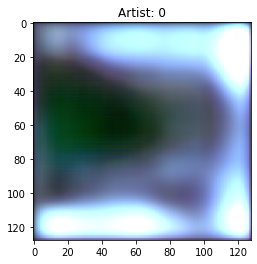

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


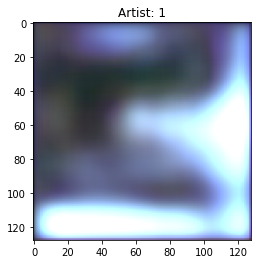

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


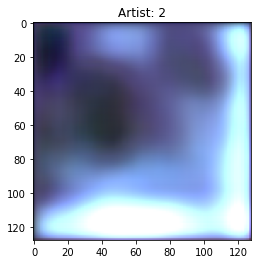

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


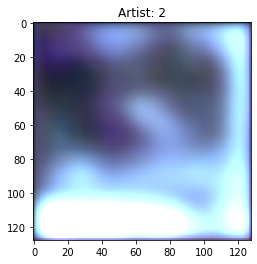

In [ ]:
random_latent_vectors = tf.random.normal(shape=(5, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, lbl[:5]], axis=1
)

g_img = cond_gan.generator(random_vector_labels)
for i in range(5):
  plt.imshow(g_img[i])
  plt.title(f"Artist: {np.argmax(lbl[i])}")
  plt.show()

## Model Evaluation

To evaluate the model, we'll be using FID

In [ ]:
from skimage import *
from sklearn import *
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

In [ ]:
# Getting the generator
generator = cond_gan.generator
# generator = get_generator()

In [ ]:
# prepare the inception v3 model
def get_FID_model():
  in_layer = keras.Input(shape=(image_size, image_size, 3))
  x = layers.Rescaling(255.0)(in_layer)
  x = layers.Resizing(299, 299)(x)
  x = layers.Lambda(keras.applications.inception_v3.preprocess_input)(x)
  out_layer= keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))(x)
  return keras.Model(inputs=in_layer, outputs=out_layer, name="FID_model")

FID_model = get_FID_model()

In [ ]:
FID_model.summary()

Model: "FID_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# inspiration: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(model, real_images, gen_images):
	# calculate activations
	act1 = model.predict(real_images)
	act2 = model.predict(gen_images)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
r_img, y = next(iter(valid_ds))
random_latent_vectors = tf.random.normal(shape=(r_img.shape[0], latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, y], axis=1
)
generated_images = generator(random_vector_labels)
r_img.shape, generated_images.shape

((86, 128, 128, 3), TensorShape([86, 128, 128, 3]))

In [ ]:
# # fid between images1 and images1, would always be 0
# fid = calculate_fid(FID_model, r_img, r_img)
# print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(FID_model, r_img, generated_images)
print('FID (different): %.3f' % fid)

FID (different): 455.904


KID (yet to be implemented)


In [ ]:
kid_image_size = 75
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [ ]:
kid = KID()
kid.reset_states()
kid.update_state(r_img, generated_images)
kid.result().numpy()

0.71066856